In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/MuonSignal/Models')
import seaborn as sns



In [2]:
plt.rcParams['figure.figsize'] = [15, 12]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

Main  = torch.load('../Data/NormData/Main_test.pt')
Aux   = torch.load('../Data/NormData/Aux_test.pt')
Truth = torch.load('../Data/NormData/Truth_test.pt')
EventMyId = torch.load('../Data/NormData/EventMyId_test.pt')

Aux = Aux.unsqueeze(2)
Truth = Truth.unsqueeze(2)

Main = Main.transpose(1,2)

# Truth = Truth.sum(dim=1).unsqueeze(1)
print(Main.shape, Aux.shape, Truth.shape)

Using Device: cuda
torch.Size([169157, 120, 3]) torch.Size([169157, 4, 1]) torch.Size([169157, 120, 1])


In [4]:
print(Aux.shape)
print(Aux.squeeze().unsqueeze(1).shape)
print(Aux.transpose(1,2).shape)

torch.Size([169157, 4, 1])
torch.Size([169157, 1, 4])
torch.Size([169157, 1, 4])


In [5]:
Name = 'Model_4_Features3'
model   = torch.load(f'../Models/{Name}.pt')
# from Model_1_0 import Model_1_2
# model = Model_1_2()
Tracker = torch.load(f'../Models/{Name}_Tracker.pt')


WantedEpoch = len(Tracker.ModelStates)
print(WantedEpoch)
model.load_state_dict(Tracker.ModelStates[WantedEpoch-1])
print(model.Name)

# Truth is now fraction of the signal in the tank
MuonTrace = Truth
# Truth = model.UnnormaliseY(Truth).sum(dim=1)/model.UnnormaliseY(Main).mean(dim=2).sum(dim=1).unsqueeze(1)


78
Model_4_Features3


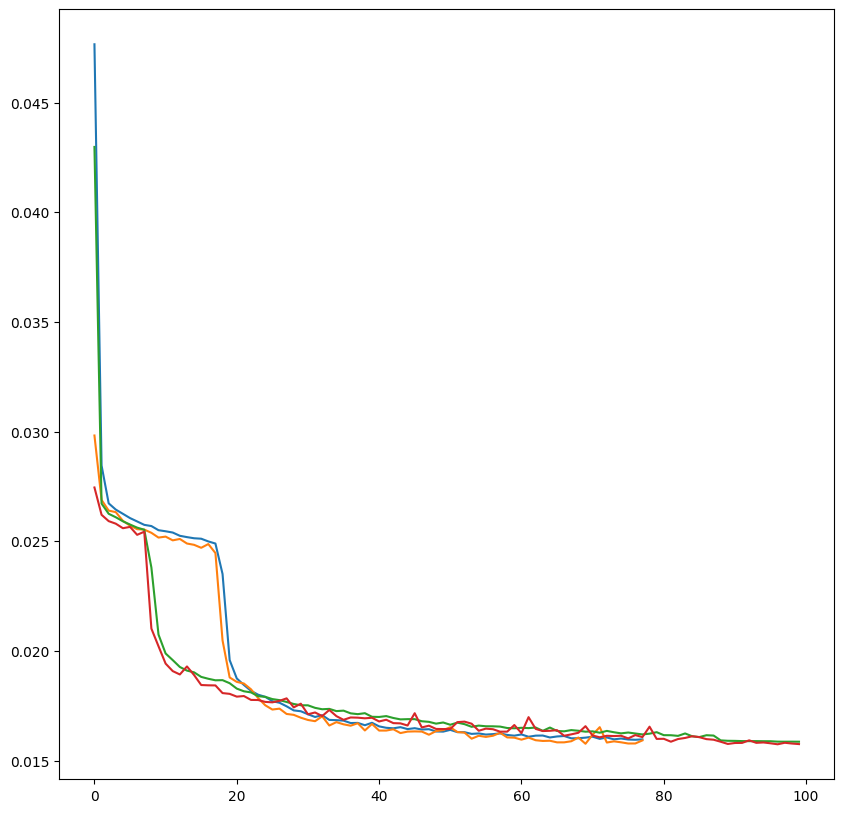

In [13]:
plt.figure(figsize=(10,10))
plt.plot(Tracker.EpochLoss)
plt.plot(Tracker.EpochValLoss)

Tracker12 = torch.load(f'../Models/Model_4_Features_Tracker.pt')
plt.plot(Tracker12.EpochLoss)
plt.plot(Tracker12.EpochValLoss)

In [8]:

model = model.to(device)
model.eval()

from Model_1_0 import MyDataset
from torch.utils.data import DataLoader

BatchSize      = 100


test_dataset = MyDataset(Main,Aux,MuonTrace)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)

pred  = np.zeros(shape = (Main.shape[0],1))
truth = np.zeros(shape = (Main.shape[0],1))
features = np.zeros(shape = (Main.shape[0],3))
measurements = np.zeros(shape = (Main.shape[0],4))
muonTraces = np.zeros(shape = (Main.shape[0],120))
totalTraces = np.zeros(shape = (Main.shape[0],120))
filled = 0
BatchN = 0
print('Beginging to compute')
with torch.no_grad():
    for batch_Main,batch_Aux,batch_Truth in dataloader_test:

        print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

        batch_Main = batch_Main.to(device)
        batch_Aux = batch_Aux.to(device)
        batch_Truth = batch_Truth.to(device)

        Current_BatchSize = batch_Main.shape[0]
        
        Results, Features = model(batch_Main,batch_Aux)
        Truths  = model.UnnormaliseY(batch_Truth).sum(dim=1)/model.UnnormaliseY(batch_Main).mean(dim=2).sum(dim=1).unsqueeze(1)
        Measurements = batch_Aux.squeeze()

               
        pred[filled: filled+Current_BatchSize] = Results.cpu().numpy()
        truth[filled: filled+Current_BatchSize] = Truths.cpu().numpy()
        features[filled: filled+Current_BatchSize] = Features.cpu().numpy()
        measurements[filled: filled+Current_BatchSize] = Measurements.cpu().numpy()
        muonTraces[filled: filled+Current_BatchSize] = batch_Truth.squeeze().cpu().numpy()
        totalTraces[filled: filled+Current_BatchSize] = batch_Main.sum(dim=2).cpu().numpy()

        filled += Current_BatchSize
        BatchN += 1

# del model

Beginging to compute
Batch 1691 of 1692

In [9]:
print(truth.shape)

(169157, 1)


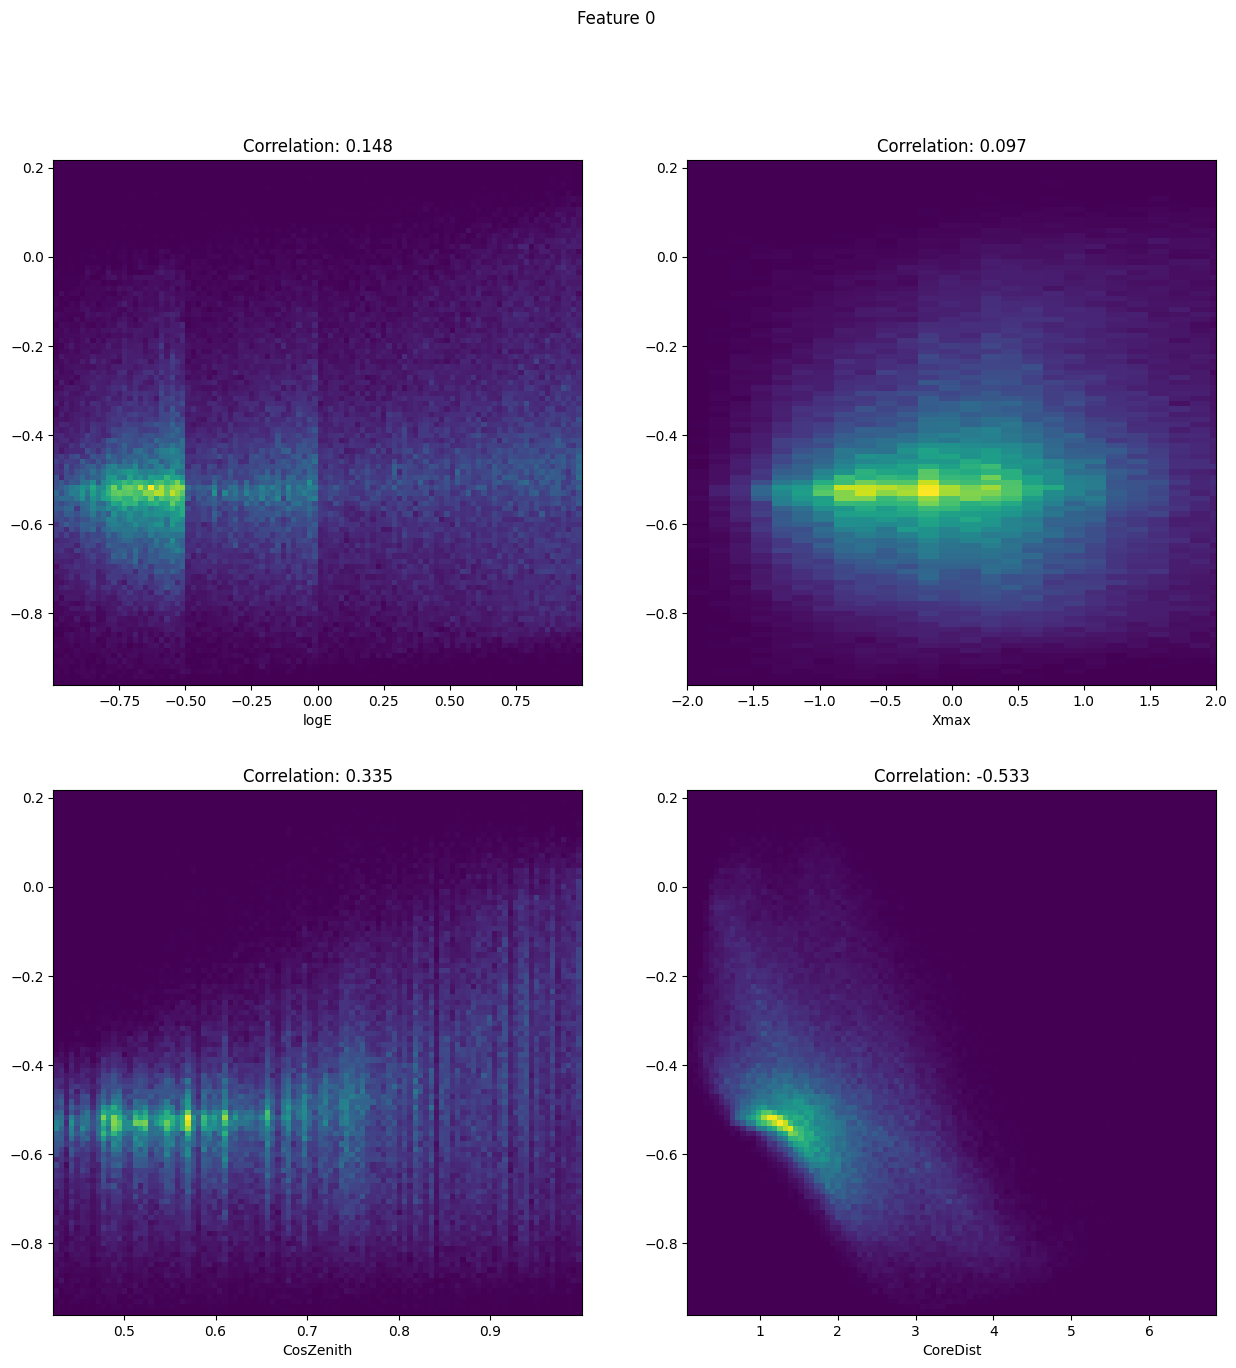

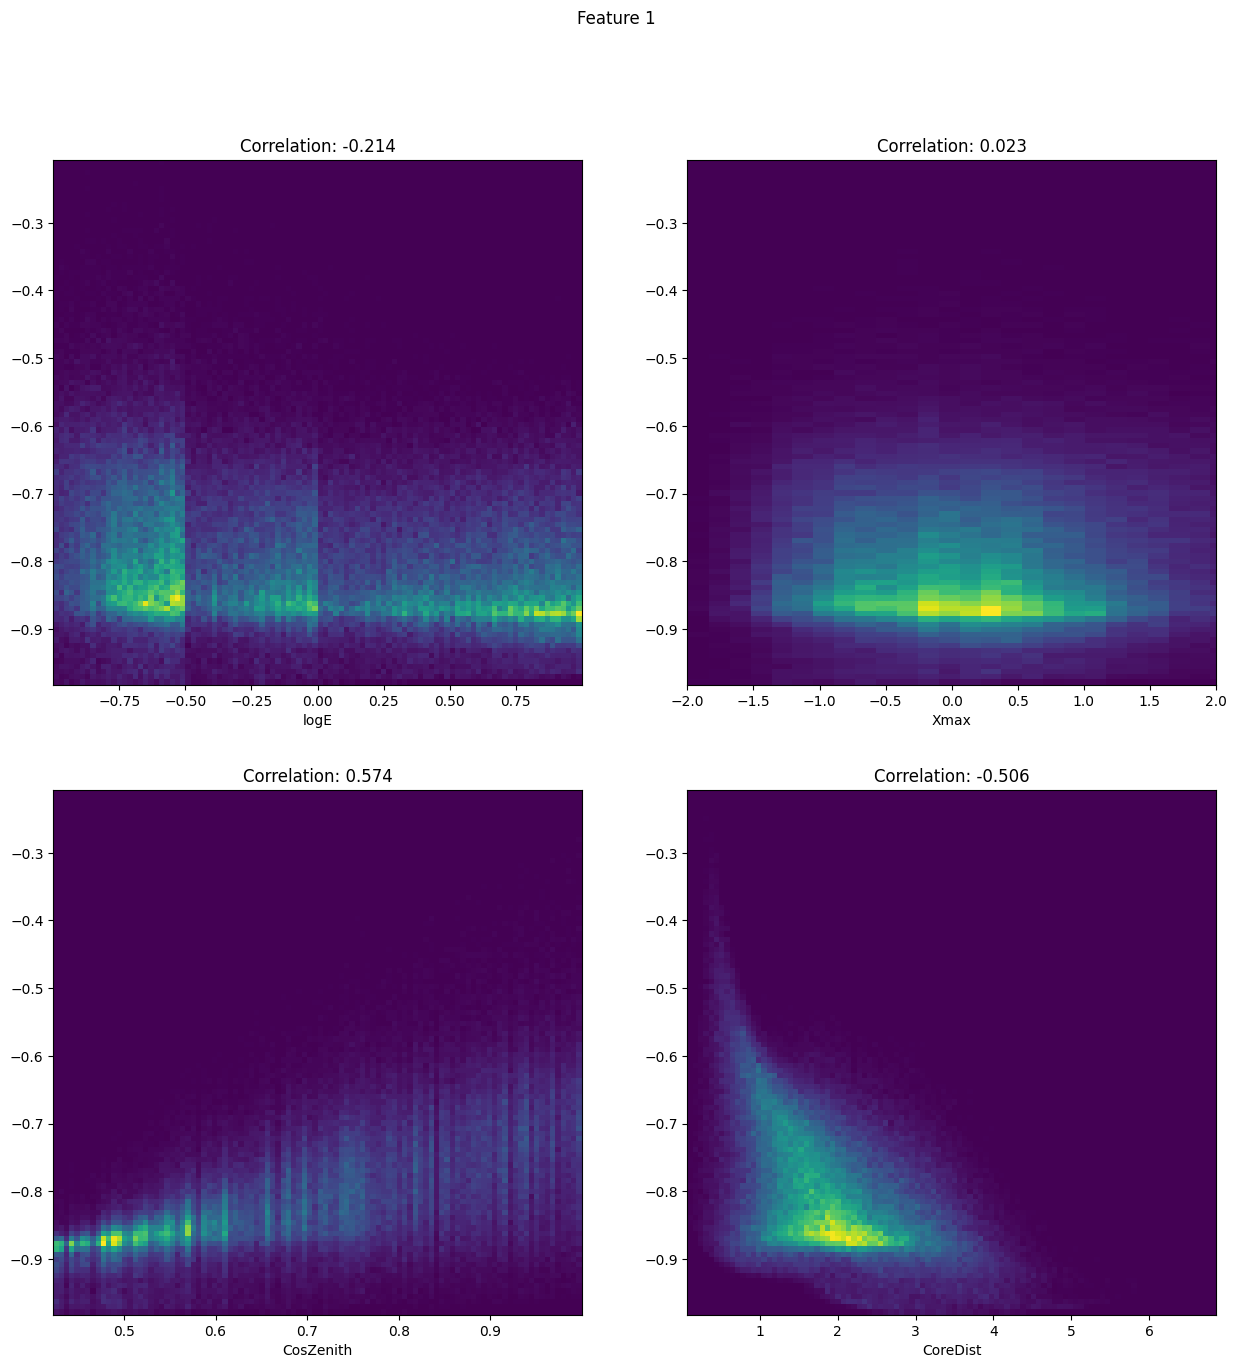

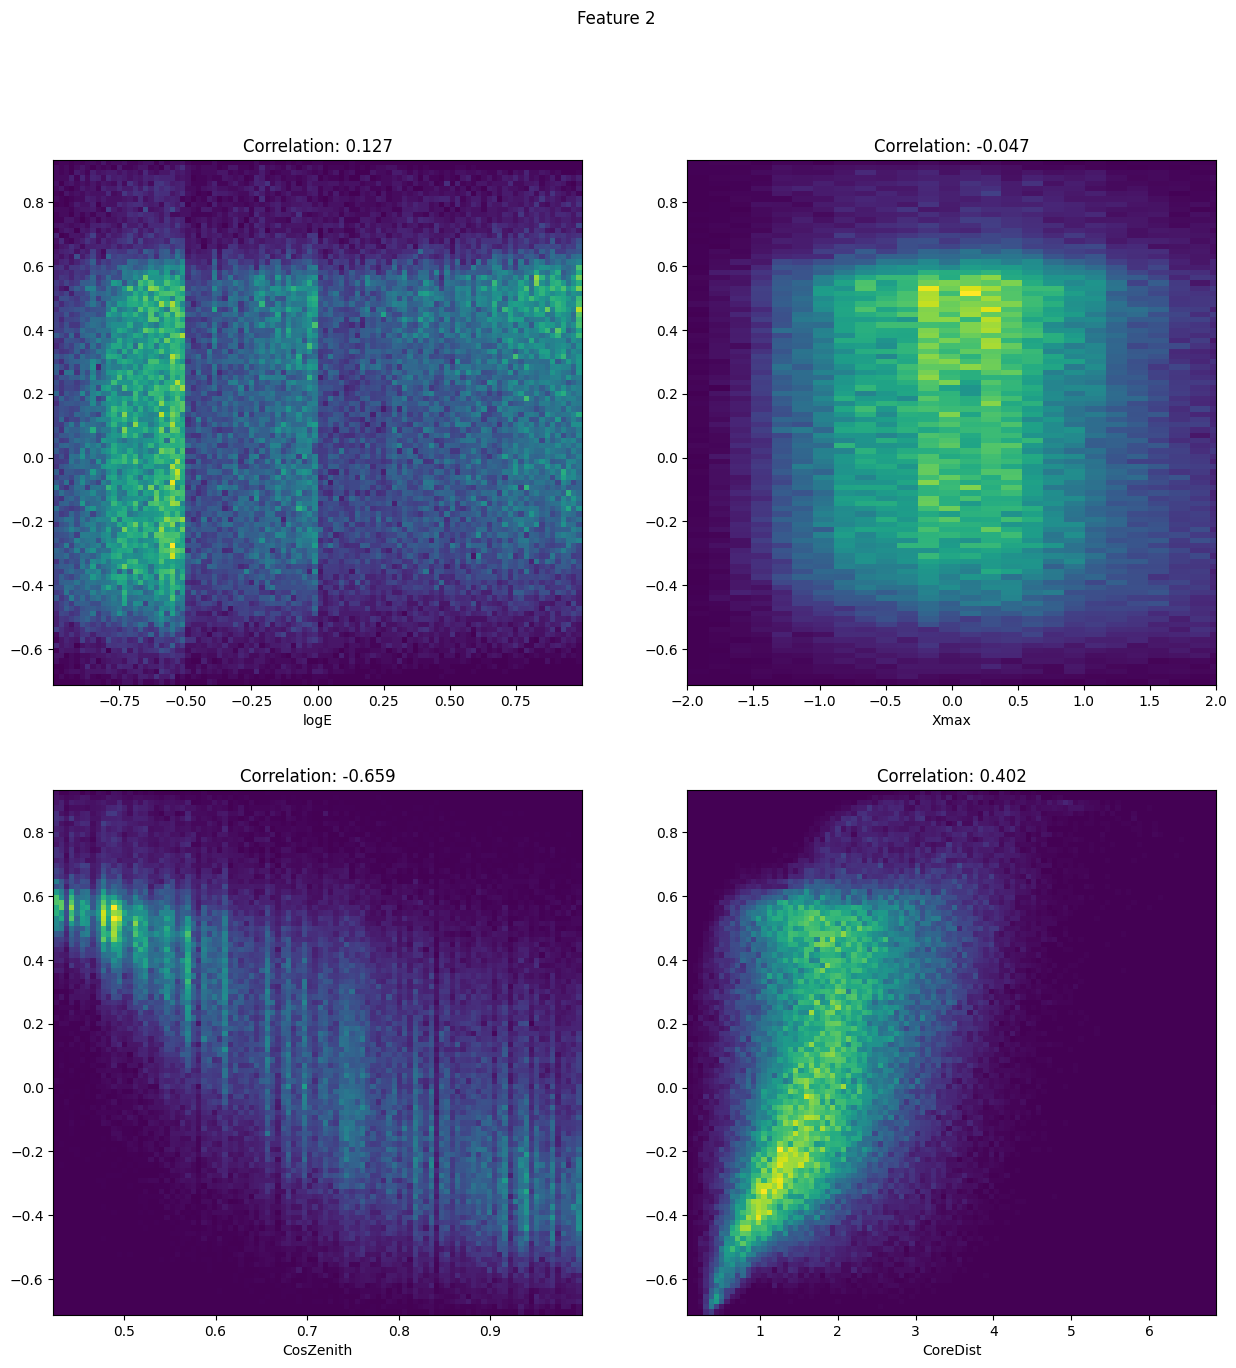

In [14]:
# Measurments vs Features


for FOI in range(3):
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    ax[0,0].hist2d(measurements[:,0],features[:,FOI],bins=100)
    ax[0,0].set_xlabel('logE')
    corr = np.corrcoef(measurements[:,0],features[:,FOI])[0,1]
    ax[0,0].set_title(f'Correlation: {corr:.3f}')

    ax[0,1].hist2d(measurements[:,1],features[:,FOI],bins=100)
    ax[0,1].set_xlabel('Xmax')
    ax[0,1].set_xlim(-2,2)
    corr = np.corrcoef(measurements[:,1],features[:,FOI])[0,1]
    ax[0,1].set_title(f'Correlation: {corr:.3f}')

    ax[1,0].hist2d(measurements[:,2],features[:,FOI],bins=100)
    ax[1,0].set_xlabel('CosZenith')
    corr = np.corrcoef(measurements[:,2],features[:,FOI])[0,1]
    ax[1,0].set_title(f'Correlation: {corr:.3f}')

    ax[1,1].hist2d(measurements[:,3],features[:,FOI],bins=100)
    ax[1,1].set_xlabel('CoreDist')
    corr = np.corrcoef(measurements[:,3],features[:,FOI])[0,1]
    ax[1,1].set_title(f'Correlation: {corr:.3f}')

    plt.suptitle(f'Feature {FOI}')

    plt.savefig(f'../Results/Feature_{FOI}.png')



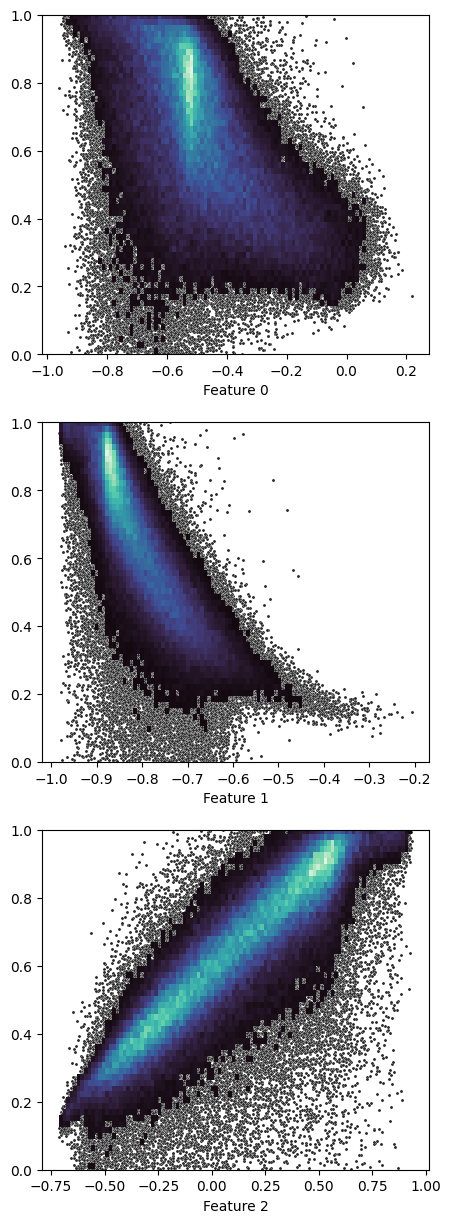

In [15]:
# fig, ax = plt.subplots(6,2,figsize=(8,24))
# for i in range(6):
#     for j in range(2):
#         FOI = i+j*6
#         sns.scatterplot(x=features[:,FOI],y=truth.squeeze(),ax=ax[i,j],s=5,color='.15')
#         sns.histplot(x=features[:,FOI],y = truth.squeeze() ,ax=ax[i,j],bins=100,range = ,pthresh=.05,cmap='mako')
#         # sns.kdeplot(x=features[:,FOI],y = truth.squeeze() ,ax=ax[i,j],levels=3,linewidths = 1)
#         # ax[i,j].hist2d(pred.squeeze(),features[:,FOI],bins=100)
#         ax[i,j].set_xlabel(f'Feature {FOI}')
#         ax[i,j].set_ylim(0,1)

fig, ax = plt.subplots(3,1,figsize=(5,15))
for i in range(3):
    FOI = i
    sns.scatterplot(x=features[:,FOI],y=truth.squeeze(),ax=ax[i],s=5,color='.15')
    sns.histplot(x=features[:,FOI],y = truth.squeeze() ,ax=ax[i],bins=100,pthresh=.05,cmap='mako')
    # sns.kdeplot(x=features[:,FOI],y = truth.squeeze() ,ax=ax[i,j],levels=3,linewidths = 1)
    # ax[i,j].hist2d(pred.squeeze(),features[:,FOI],bins=100)
    ax[i].set_xlabel(f'Feature {FOI}')
    ax[i].set_ylim(0,1)
    

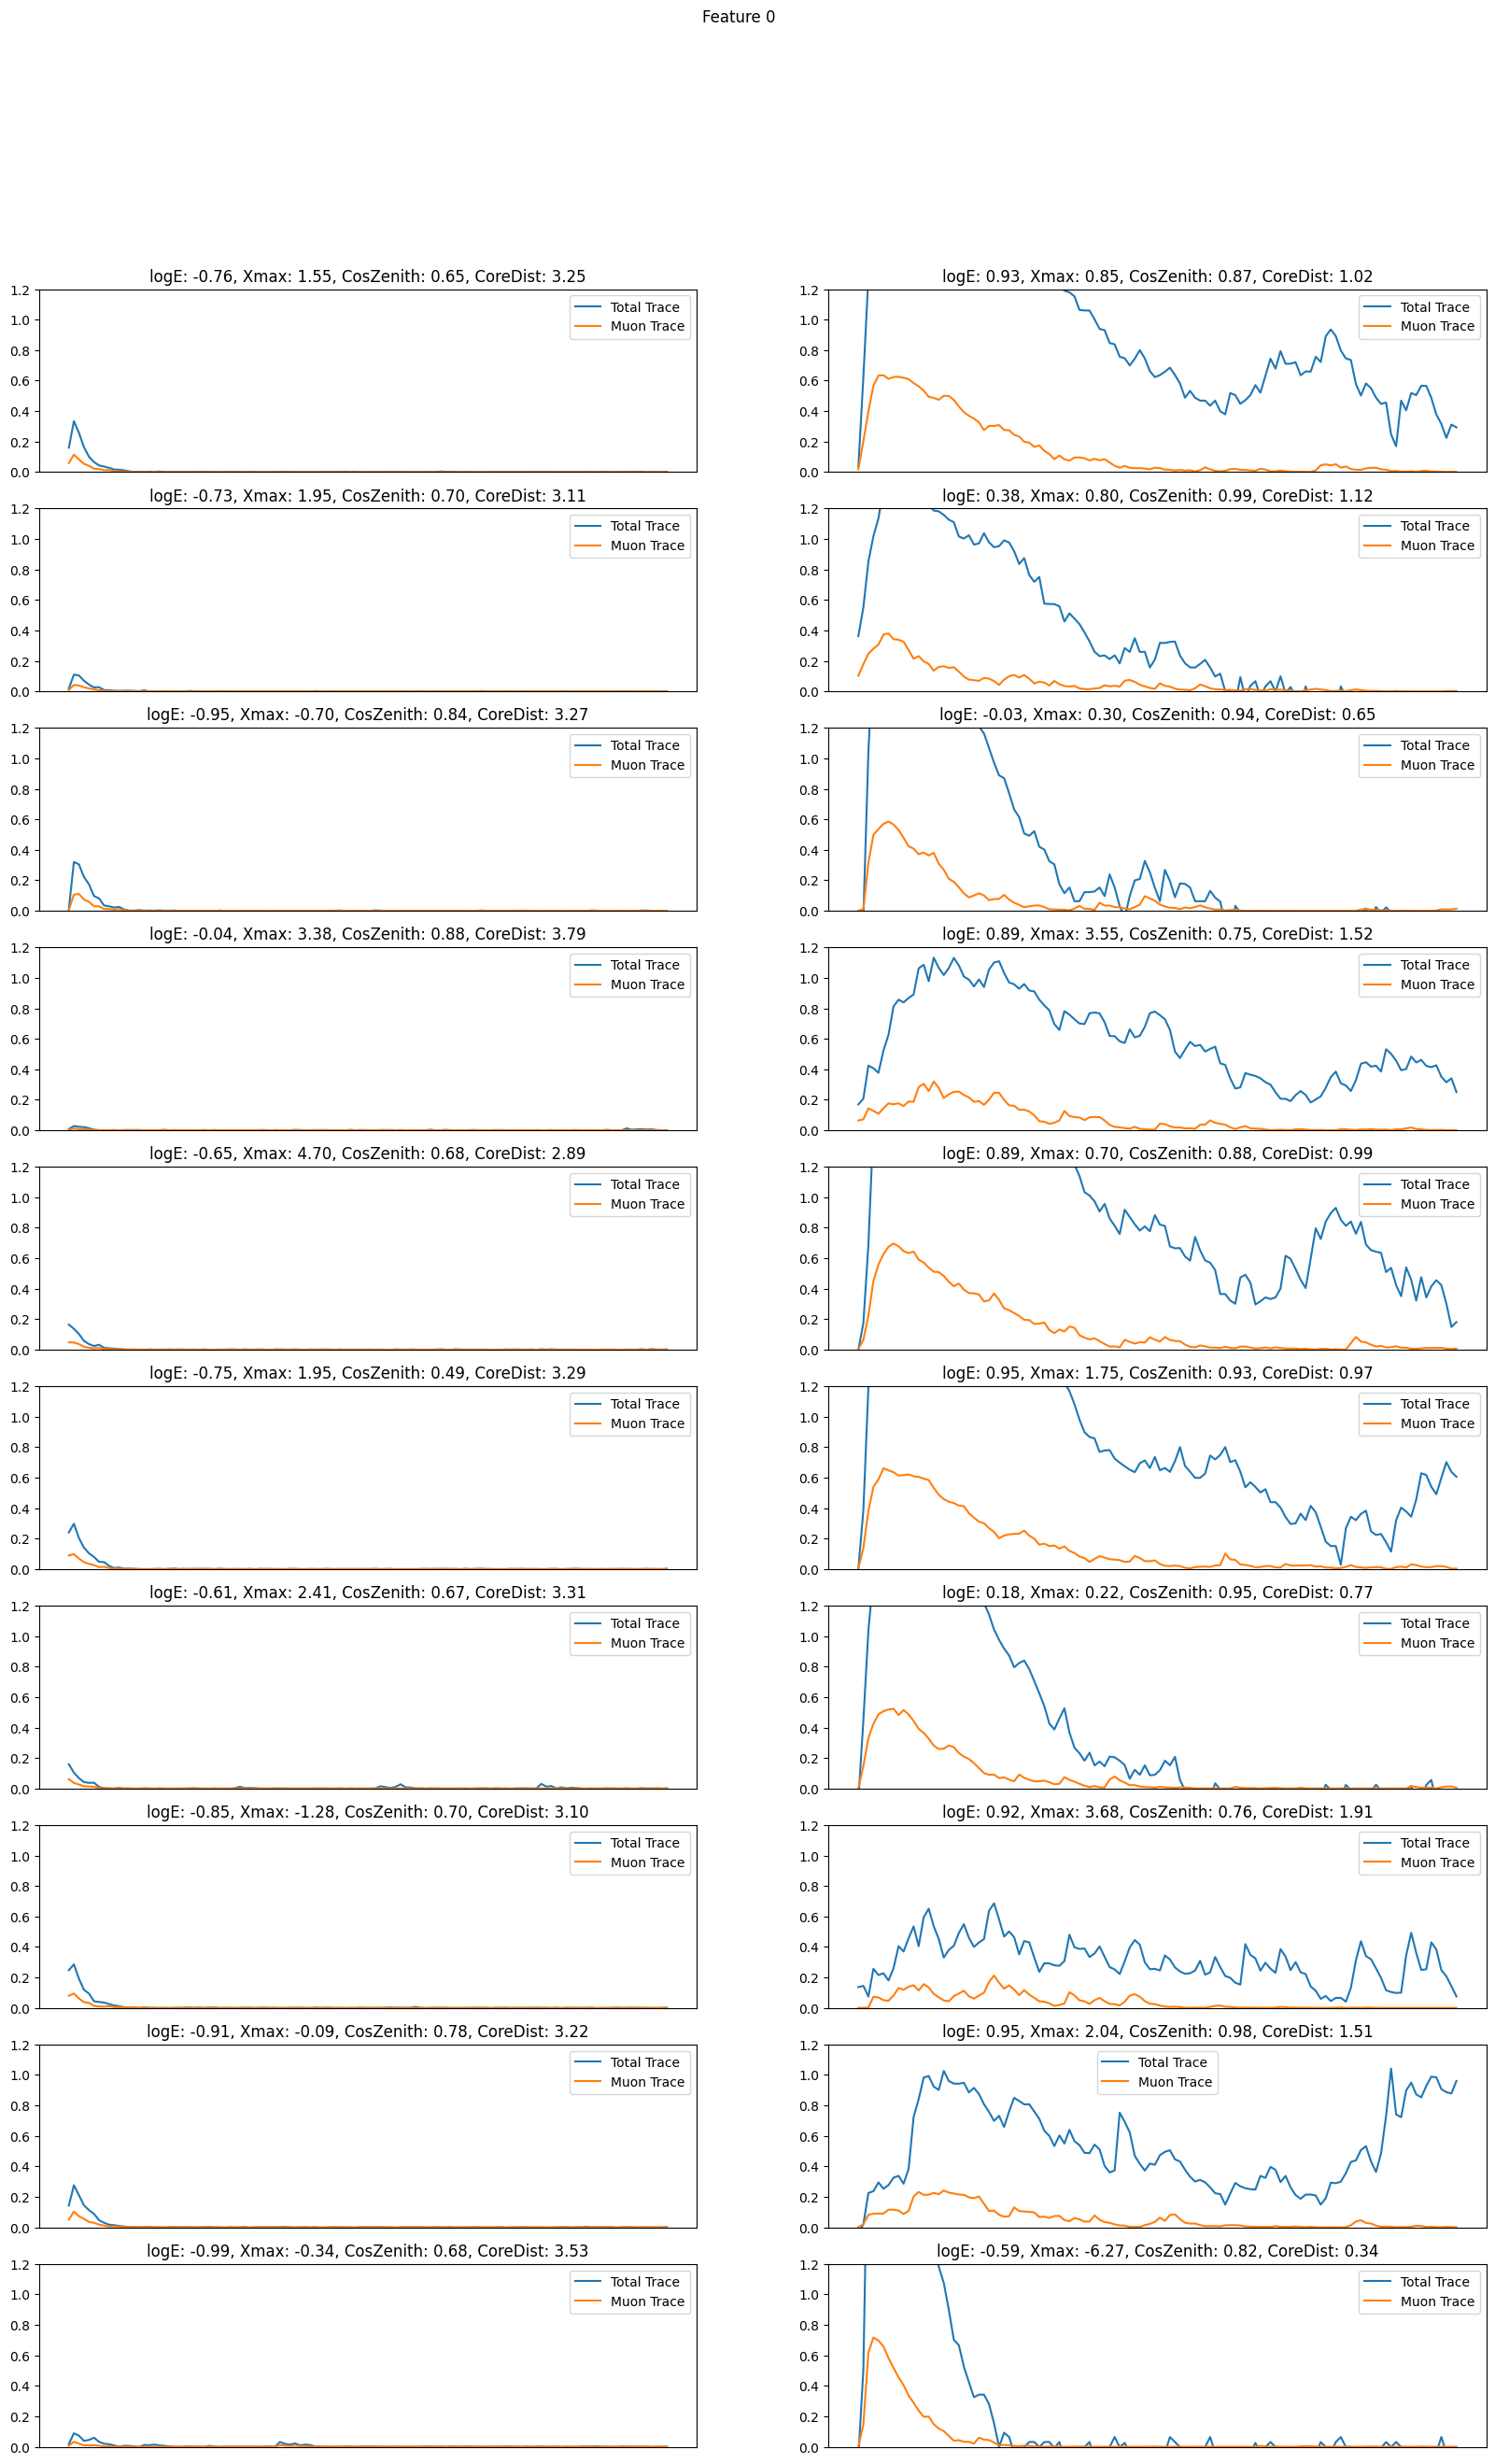

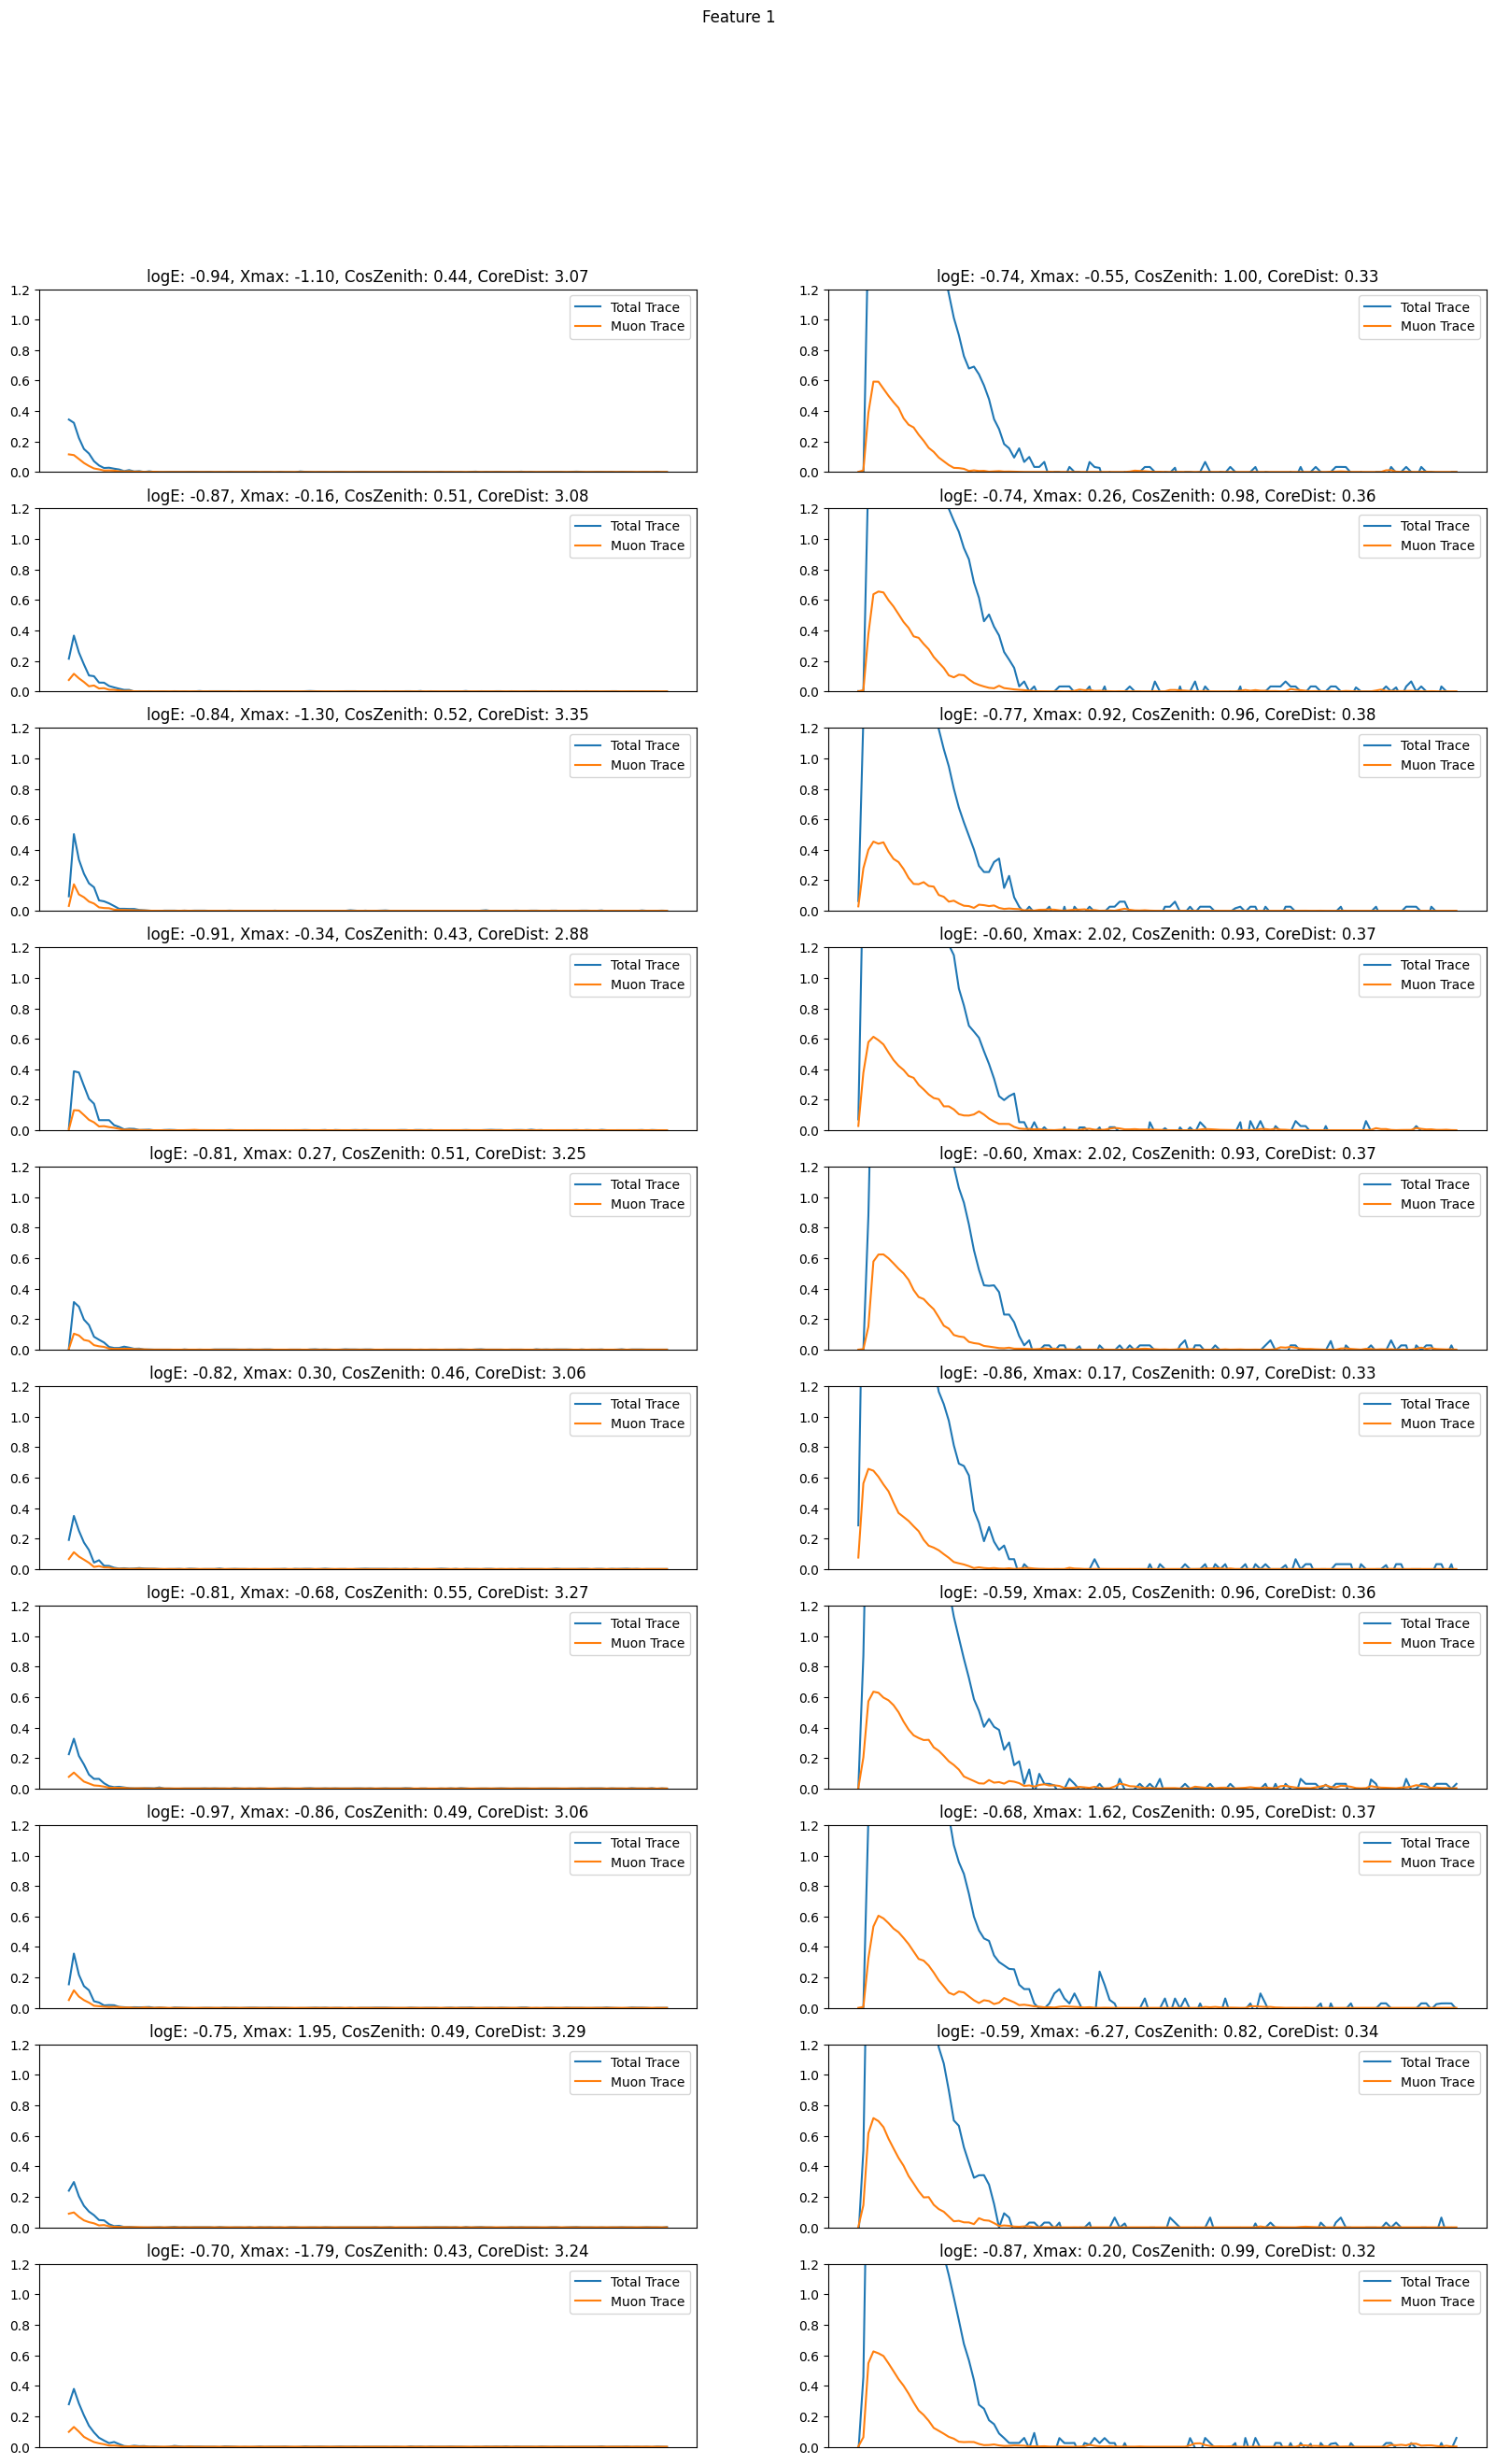

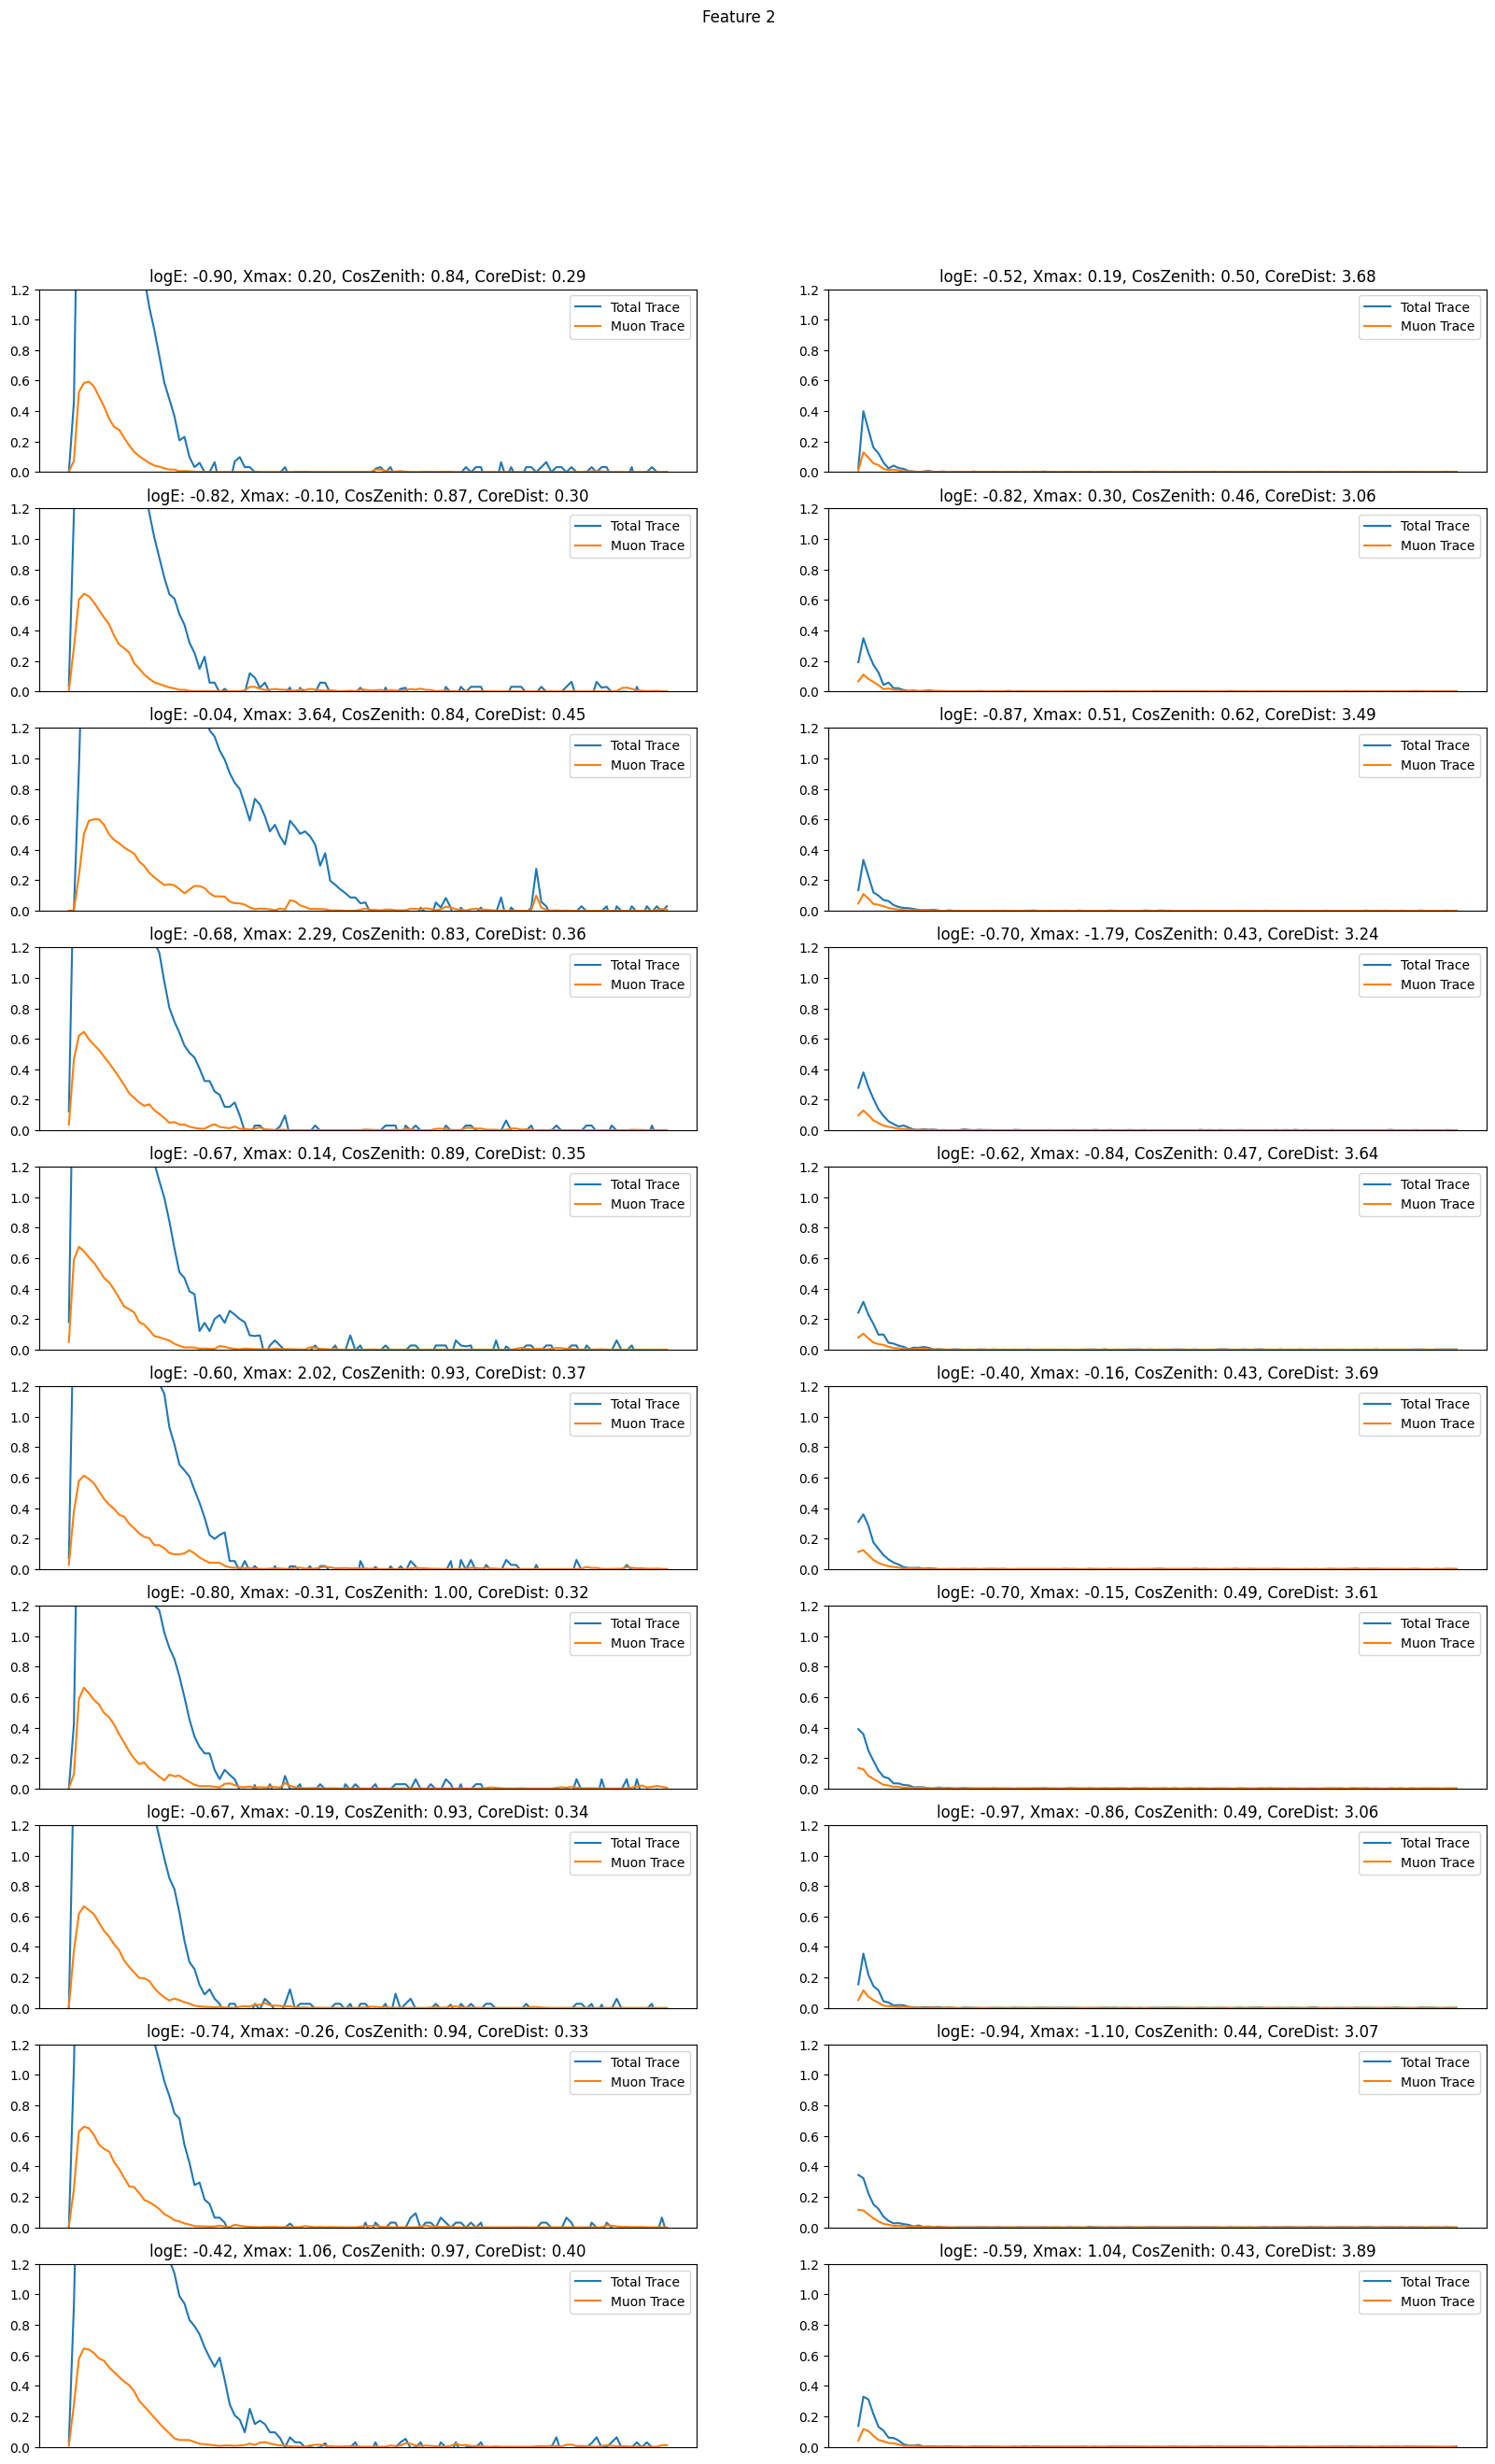

In [16]:
how_many = 10
for FOI in range(3):
    # FOI = 0  # Feature of Interest

    Smallest_FOI_Loc = np.argpartition(features[:,FOI],how_many)[:how_many]
    # print(Smallest_FOI_Loc)

    Largest_FOI_Loc = np.argpartition(features[:,FOI],-how_many)[-how_many:]
    # print(Largest_FOI_Loc)


    fig,ax = plt.subplots(how_many,2,figsize=(20,3*how_many))
    for i,loc in enumerate(Smallest_FOI_Loc):
        Traces = totalTraces[loc,...]
        MuonTrace = muonTraces[loc,...]
        logE,Xmax,CosZenith,CoreDist = measurements[loc,:]
        ax[i,0].plot(Traces,label = 'Total Trace')    
        ax[i,0].plot(MuonTrace,label = 'Muon Trace')
        # ax[i,0].plot(MuonTrace/Traces,label = 'Muon Trace')
        ax[i,0].set_ylim(0,1.2)
        ax[i,0].set_title(f'logE: {logE:.2f}, Xmax: {Xmax:.2f}, CosZenith: {CosZenith:.2f}, CoreDist: {CoreDist:.2f}')
        ax[i,0].set_xticks([],[])
        ax[i,0].legend()
    for i,loc in enumerate(Largest_FOI_Loc):
        Traces = totalTraces[loc,...]
        MuonTrace = muonTraces[loc,...]
        logE,Xmax,CosZenith,CoreDist = measurements[loc,:]
        ax[i,1].plot(Traces,label = 'Total Trace')
        ax[i,1].plot(MuonTrace,label = 'Muon Trace')
        # ax[i,1].plot(MuonTrace/Traces,label = 'Muon Trace')
        ax[i,1].set_ylim(0,1.2)
        ax[i,1].set_title(f'logE: {logE:.2f}, Xmax: {Xmax:.2f}, CosZenith: {CosZenith:.2f}, CoreDist: {CoreDist:.2f}')
        ax[i,1].set_xticks([],[])
        ax[i,1].legend()
    plt.suptitle(f'Feature {FOI}')
    plt.savefig(f'../Results/Feature_Traces/Feature_{FOI}_Sig_Traces.png')

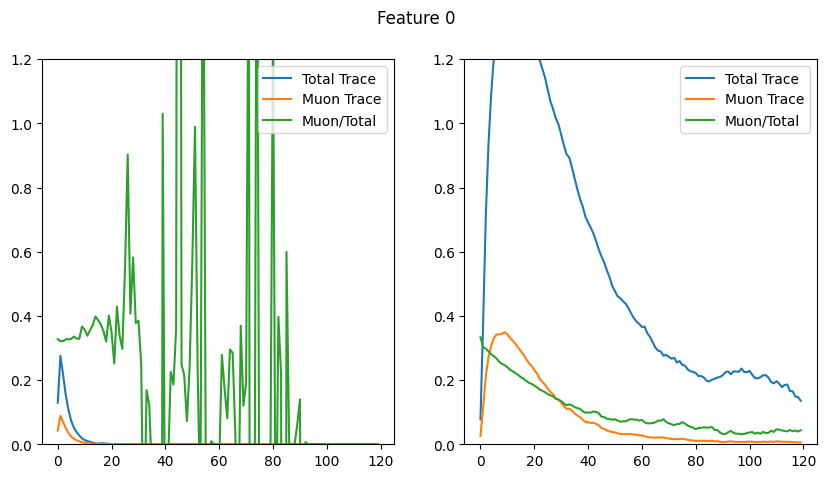

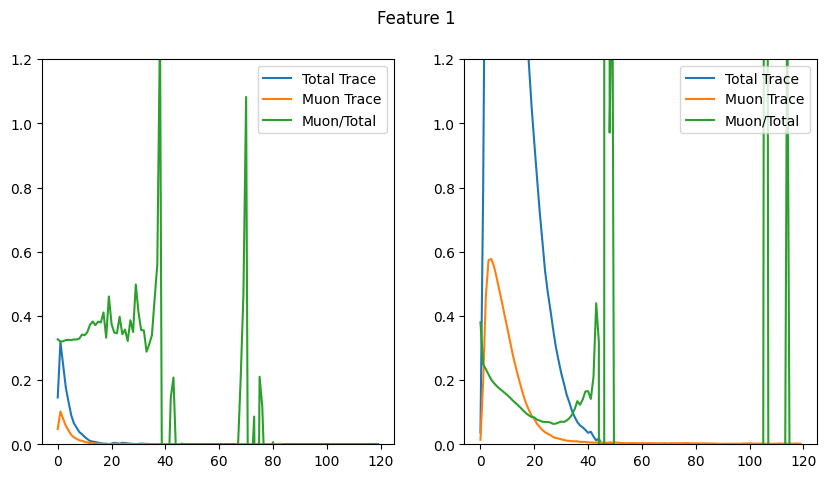

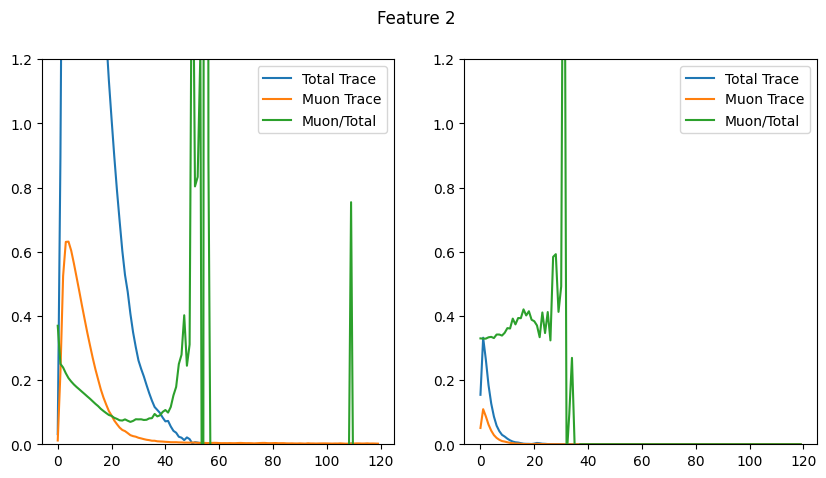

In [18]:
how_many = 100
for FOI in range(3):
    # FOI = 0  # Feature of Interest

    Smallest_FOI_Loc = np.argpartition(features[:,FOI],how_many)[:how_many]
    # print(Smallest_FOI_Loc)

    Largest_FOI_Loc = np.argpartition(features[:,FOI],-how_many)[-how_many:]
    # print(Largest_FOI_Loc)

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    Traces = totalTraces[Smallest_FOI_Loc,...].mean(axis=0)
    MuonTrace = muonTraces[Smallest_FOI_Loc,...].mean(axis=0)
    Ratio = MuonTrace/Traces
    ax[0].plot(Traces,label = 'Total Trace')
    ax[0].plot(MuonTrace,label = 'Muon Trace')
    ax[0].plot(Ratio,label = 'Muon/Total')
    ax[0].set_ylim(0,1.2)
    ax[0].legend()
    Traces = totalTraces[Largest_FOI_Loc,...].mean(axis=0)
    MuonTrace = muonTraces[Largest_FOI_Loc,...].mean(axis=0)
    Ratio = MuonTrace/Traces
    ax[1].plot(Traces,label = 'Total Trace')
    ax[1].plot(MuonTrace,label = 'Muon Trace')
    ax[1].plot(Ratio,label = 'Muon/Total')
    ax[1].set_ylim(0,1.2)
    ax[1].legend()
    plt.suptitle(f'Feature {FOI}')
    plt.savefig(f'../Results/Feature_AverageSignal/Feature_{FOI}_Sig_Traces.png')


In [19]:
Tracker.ModelStates[-1].keys()

odict_keys(['Bi_LSTM.weight_ih_l0', 'Bi_LSTM.weight_hh_l0', 'Bi_LSTM.bias_ih_l0', 'Bi_LSTM.bias_hh_l0', 'Bi_LSTM.weight_ih_l0_reverse', 'Bi_LSTM.weight_hh_l0_reverse', 'Bi_LSTM.bias_ih_l0_reverse', 'Bi_LSTM.bias_hh_l0_reverse', 'LSTM.weight_ih_l0', 'LSTM.weight_hh_l0', 'LSTM.bias_ih_l0', 'LSTM.bias_hh_l0', 'CollectLSTM.weight_ih_l0', 'CollectLSTM.weight_hh_l0', 'CollectLSTM.bias_ih_l0', 'CollectLSTM.bias_hh_l0', 'FC.weight', 'FC.bias', 'FC2.weight', 'FC2.bias'])

In [24]:
from matplotlib.colors import Normalize
# import gridspec
import matplotlib.gridspec as gridspec
def plotTrace(trace, Mtrace, box_values, MuonFraction,MuonFractionPred):
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 0.2])

    # Plot trace in the top section
    ax0 = plt.subplot(gs[0])
    ax0.plot(trace, label='Total')
    ax0.plot(Mtrace, label='Muon')
    ax0.set_xticks([])
    ax0.set_ylabel('Amplitude')
    ax0.set_ylim(0, 1.2)
    ax0.legend()

    # Add line and dot for MuonFraction
    line_X = [80, 100]
    line_Y = [0.9, 0.9]
    ax0.plot(line_X, line_Y, 'k-')
    cross_position = [80 + 20 * MuonFraction, 0.9]
    dot_position = [80 + 20 * MuonFractionPred, 0.9]
    ax0.plot(cross_position[0], cross_position[1], 'rx', markersize=15)
    ax0.plot(dot_position[0], dot_position[1], 'ko', markersize=10)




    # Plot boxes in the bottom section
    ax1 = plt.subplot(gs[1])
    cmap = plt.get_cmap('bwr')
    for i, val in enumerate(box_values):
        color = cmap((-val + 1) / 2)
        rect = plt.Rectangle((i, 0), 1, 1, facecolor=color)
        ax1.add_patch(rect)

    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 1)
    ax1.set_aspect('equal', adjustable='box')
    ax1.axis('off')

    # Colorbar
    ax2 = plt.subplot(gs[2])
    norm = Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=ax2, orientation='horizontal')
    cb.set_label('Value')

    plt.show()


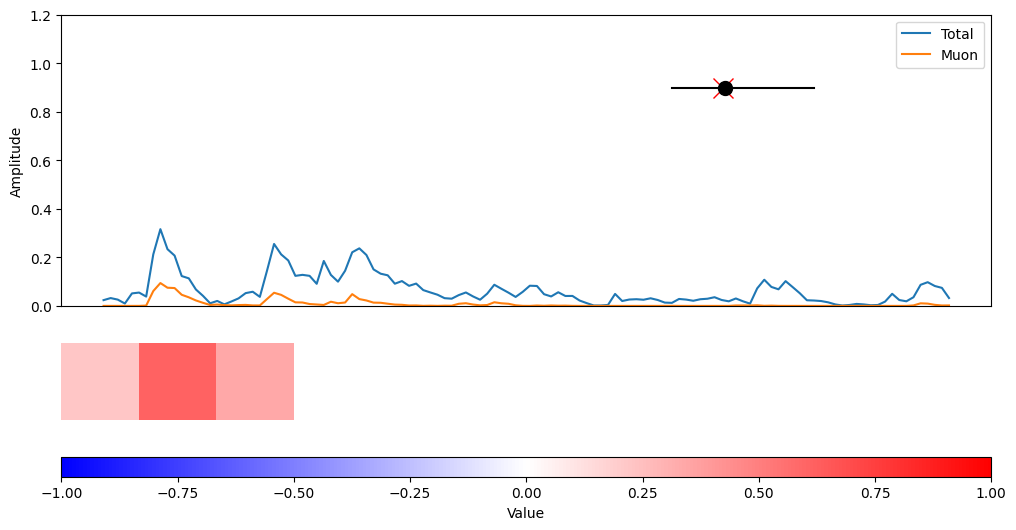

In [94]:
N = np.random.randint(0,Main.shape[0])

Traces    = totalTraces[N,...]
MTraces   = muonTraces[N,...]
Features  = features[N,:]
Mfrac     = truth[N]
MfracP    = pred[N]

plotTrace(Traces,MTraces,Features,Mfrac,MfracP)